In [1]:
# 多项式回归
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 生成数据集
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.6108],
         [-0.0088]]),
 tensor([[ 1.0000e+00, -1.6108e+00,  1.2974e+00, -6.9661e-01,  2.8053e-01,
          -9.0377e-02,  2.4264e-02, -5.5835e-03,  1.1242e-03, -2.0122e-04,
           3.2413e-05, -4.7465e-06,  6.3714e-07, -7.8948e-08,  9.0836e-09,
          -9.7548e-10,  9.8207e-11, -9.3056e-12,  8.3276e-13, -7.0601e-14],
         [ 1.0000e+00, -8.7546e-03,  3.8321e-05, -1.1183e-07,  2.4475e-10,
          -4.2854e-13,  6.2528e-16, -7.8201e-19,  8.5577e-22, -8.3244e-25,
           7.2876e-28, -5.8000e-31,  4.2314e-34, -2.8495e-37,  1.7819e-40,
          -1.0370e-43,  0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00]]),
 tensor([-5.2684,  4.9747]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
# train(poly_features[:n_train, :4], poly_features[n_train:, :4],
#       labels[:n_train], labels[n_train:])

In [7]:
# # 从多项式特征中选择前2个维度，即1和x
# train(poly_features[:n_train, :2], poly_features[n_train:, :2],
#       labels[:n_train], labels[n_train:])

In [8]:
# 从多项式特征中选取所有维度
# train(poly_features[:n_train, :], poly_features[n_train:, :],
#       labels[:n_train], labels[n_train:], num_epochs=1500)

In [9]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    
#     animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
#                             xlim=[1, num_epochs], ylim=[1e-3, 1e2],
#                             legend=['train', 'test'])
  
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
#         if epoch == 0 or (epoch + 1) % 20 == 0:
#             animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
#                                      evaluate_loss(net, test_iter, loss)))
#     print('weight:', net[0].weight.data.numpy())
    return evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)

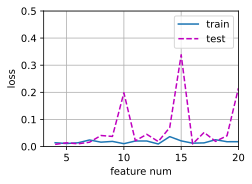

In [10]:
# 从3阶到20阶的训练损失和模型复杂度关系图

animator = d2l.Animator(xlabel='feature num', ylabel='loss', 
                            xlim=[3, 20], ylim=[0, 5e-1],  
                            legend=['train', 'test'])

for feature_num in range(4, 21):
    # 没看懂前面代码怎么初始化权重的，全部重新初始一遍
    max_degree = 20  # 多项式的最大阶数
    n_train, n_test = 100, 100  # 训练和测试数据集大小
    true_w = np.zeros(max_degree)  # 分配大量的空间
    true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

    features = np.random.normal(size=(n_train + n_test, 1))
    np.random.shuffle(features)
    poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
    for i in range(max_degree):
        poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
    # labels的维度:(n_train+n_test,)
    labels = np.dot(poly_features, true_w)
    labels += np.random.normal(scale=0.1, size=labels.shape)
    true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]
    features[:2], poly_features[:2, :], labels[:2]
    
    # 训练
    train_loss, test_loss = train(poly_features[:n_train, :feature_num], poly_features[n_train:, :feature_num], 
          labels[:n_train], labels[n_train:])
    print(feature_num, train_loss, test_loss)
    animator.add(feature_num, (train_loss, test_loss))

# test loss 增加而  train loss 不咋变说明可能过拟合了